In [61]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
from torch.optim import Adam

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 64
BATCH_SIZE = 128

T = 300

beta = torch.linspace(0.0001, 0.02, T)

alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, axis=0)
alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)

sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)

posterior_variance = beta * (1. - alpha_bar_prev) / (1. - alpha_bar)

In [63]:
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device):
    noise = torch.randn_like(x_0)
    sqrt_alpha_bar_t = get_index_from_list(sqrt_alpha_bar, t, x_0.shape)
    sqrt_one_minus_alpha_bar_t = get_index_from_list(
        sqrt_one_minus_alpha_bar, t, x_0.shape
    )
    return (sqrt_alpha_bar_t.to(device) * x_0.to(device)
            + sqrt_one_minus_alpha_bar_t.to(device) * noise.to(device), noise.to(device))

In [64]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

def load_transformed_dataset(dataset):
    data_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), 
            transforms.Lambda(lambda t: (t * 2) - 1)
        ]
    )

    return dataset(root='.', download=True, transform=data_transform)


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [65]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class Unet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, image_size: int, image_channels: int):
        super().__init__()
        down_channels = (image_size, image_size * 2, image_size * 4, image_size * 8)
        up_channels = down_channels[::-1]
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) 
                                    for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
                                  for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [66]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [67]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    beta_t = get_index_from_list(beta, t, x.shape)
    sqrt_one_minus_alpha_bar_t = get_index_from_list(
        sqrt_one_minus_alpha_bar, t, x.shape
    )
    sqrt_recip_alpha_t = get_index_from_list(sqrt_recip_alpha, t, x.shape)

    model_mean = sqrt_recip_alpha_t * (
        x - beta_t * model(x, t) / sqrt_one_minus_alpha_bar_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(1, 1))
    plt.axis('off')

    for i in range(T - 1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)

    show_tensor_image(img.detach().cpu())
    plt.show()  

In [68]:
data_set = load_transformed_dataset(torchvision.datasets.Flowers102)

dataloader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [69]:
model = Unet(
    image_size=64,
    image_channels=3
).to(device)

In [92]:
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(50):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Loss: {loss.item()} ")

Epoch 0 | Loss: 0.1648307740688324 
Epoch 1 | Loss: 0.19880640506744385 
Epoch 2 | Loss: 0.17743518948554993 
Epoch 3 | Loss: 0.17739646136760712 
Epoch 4 | Loss: 0.15641534328460693 
Epoch 5 | Loss: 0.17243413627147675 
Epoch 6 | Loss: 0.17220841348171234 
Epoch 7 | Loss: 0.17862653732299805 
Epoch 8 | Loss: 0.15946584939956665 
Epoch 9 | Loss: 0.17338316142559052 
Epoch 10 | Loss: 0.15487447381019592 
Epoch 11 | Loss: 0.18087153136730194 
Epoch 12 | Loss: 0.16505873203277588 
Epoch 13 | Loss: 0.1666247546672821 
Epoch 14 | Loss: 0.17139482498168945 
Epoch 15 | Loss: 0.17641887068748474 
Epoch 16 | Loss: 0.19186846911907196 
Epoch 17 | Loss: 0.1714743822813034 
Epoch 18 | Loss: 0.16938045620918274 
Epoch 19 | Loss: 0.16296647489070892 
Epoch 20 | Loss: 0.17148177325725555 
Epoch 21 | Loss: 0.17401432991027832 
Epoch 22 | Loss: 0.15098664164543152 
Epoch 23 | Loss: 0.16311734914779663 
Epoch 24 | Loss: 0.1635390818119049 
Epoch 25 | Loss: 0.16835734248161316 
Epoch 26 | Loss: 0.1625509

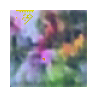

In [122]:
sample_plot_image()